In [219]:
import requests, re
from lxml import etree
import xml.etree.ElementTree as ET
from tqdm import tqdm_notebook as tqdm
import zipfile, urllib
import pandas as pd
pd.set_option('display.max_columns', None)
from scipy import stats
import collections
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
def get_data_urls(year_range=None):
    """
        Args:
            year_range - List: Parameter will take either a 2 value list or `None`. If parameter is a list, results will be restricted to years less than the first value and greater than the second.
                Example: [2003, 2010] - Files returned : 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010
                Example: [2003, 2003] - Files returned : 2003
        Returns:
            all_data_links - List: List of links filtered by the requested `year_range`
    """
    url_base = 'https://exporter.nih.gov'
    url_search = url_base + '/ExPORTER_Catalog.aspx'

    url_text = requests.get(url_search).text

    parser = etree.XMLParser(recover=True)
    root = ET.fromstring(url_text, parser=parser)
    
    #### I stole this code from the internet but it will replace the prefix that gets added
    #### There's probably a better way to do this
    for elem in root.getiterator():
        if not hasattr(elem.tag, 'find'): continue
        i = elem.tag.find('}')
        if i >= 0:
            elem.tag = elem.tag[i+1:]
    ####
    data_2019 = [i.get('href') for i in root.findall('.//tr[@class="row_bg"]/td//a')]
    data_2019 = [i for i in data_2019  if ('XMLData' in i) and ('2019' in i)]
    data_2019 = [url_base + '/' + i for i in data_2019]
    ### Range + 1900 goes from 1985 to 2018    
    years = [1900 + i for i in range(85,119)]
    years = sorted(years, reverse = True)
    fy_links = [f'https://exporter.nih.gov/XMLData/final/RePORTER_PRJ_X_FY{year}.zip' for year in years]
    fy_links

    all_data_links = data_2019 + fy_links
    ### Make a copy because we modifying in place ya'll
    all_data_loop = all_data_links.copy()
    if year_range is not None:
        for link in all_data_loop:
            link_year = re.search('FY.{4}.*\.zip', link).group()
            ### Remove '.zip' then remove any '_\d' stuff that 2019 files have
            link_year = link_year.split('.')[0].split('_')[0]
            ### Remove 'FY'
            link_year = link_year[2:]
            link_year = int(link_year)
            if (link_year < year_range[0]) or (link_year > year_range[1]):
                ### modifying in place ya'll
                all_data_links.remove(link)
                
    return all_data_links

In [264]:
def extract_xml_from_zip(zip_links, out_format = 'dict'):
    """
    Function takes in a link to a zip file with an XML inside and will return a data structure containing that data.
    Data structure can be either a dictionary or a dataframe.
    
    """
    if isinstance(zip_links, str):
        zip_links = [zip_links]
    projects_dict = {}
    for zip_link in zip_links:
        zip_file = zip_link.split('/')[-1]
        file_name = zip_file.split('.')[0]
        xml_name = file_name + '.xml'
        with zipfile.ZipFile(urllib.request.urlretrieve(zip_link, filename=None)[0], 'r') as archive:
            xml_data = archive.read(xml_name)
        rows = []
        root = ET.fromstring(xml_data)

        
        for project in root.findall('./row'):
            project_dict = {}
            for column in project.findall('./'):
                column_header = column.tag.lower()
                if column_header == 'project_terms':
                    project_dict['project_terms'] = [i.text for i in column.findall('./')]
                else:
                    project_dict[column_header] = column.text
                
            project_dict['data_source'] = zip_link
            projects_dict[project_dict['application_id']] = project_dict
    
    if out_format.lower() == 'df':
        projects_dict = pd.DataFrame.from_dict(projects_dict, orient='index')
    return projects_dict

In [249]:
urls = get_data_urls([2003, 2003])
urls

['https://exporter.nih.gov/XMLData/final/RePORTER_PRJ_X_FY2003.zip']

In [265]:
example_df = extract_xml_from_zip(urls, out_format = 'df')

example_df.head()

,application_id,activity,administering_ic,application_type,arra_funded,budget_start,budget_end,foa_number,full_project_num,funding_ics,fy,nih_spending_cats,org_city,org_country,org_district,org_duns,org_dept,org_fips,org_state,org_zipcode,ic_name,org_name,pis,project_terms,project_title,project_start,project_end,phr,serial_number,study_section,study_section_name,support_year,suffix,subproject_id,total_cost,total_cost_sub_project,core_project_num,cfda_code,program_officer_name,ed_inst_type,award_notice_date,data_source
6175078,6175078,K05,DA,5,None,09/01/2003,08/31/2004,PA-95-51,5K05DA000378-03,NIDA:129422\,2003,None,SALT LAKE CITY,UNITED STATES,02,None,PHARMACOLOGY,US,UT,84112,NATIONAL INSTITUTE ON DRUG ABUSE,UNIVERSITY OF UTAH,None,"[neurotoxicology, psychopharmacology, drug abu...",PHARMACOLOGY AND TOXICOLOGY OF METHAMPHETAMINE...,08/01/1998,08/31/2007,None,378,ZDA1,Special Emphasis Panel,3,None,None,129422,None,K05DA000378,279,"FRANKENHEIM, JERRY",SCHOOLS OF PHARMACY,2003-08-28,https://exporter.nih.gov/XMLData/final/RePORTE...
6185132,6185132,F31,MH,5,None,11/16/2002,11/15/2003,None,5F31MH012113-03,NIMH:25194\,2003,None,AURORA,UNITED STATES,01,015634884,SOCIAL SCIENCES,US,CO,800452570,NATIONAL INSTITUTE OF MENTAL HEALTH,UNIVERSITY OF COLORADO DENVER/HSC DENVER,None,"[female, reproduction, decision making, HIV in...",REPRODUCTIVE DECISION MAKING AMONG HIV INFECTE...,08/06/2000,None,None,12113,CAIR,Clinical AIDS and Immunology Review Committee,3,None,None,25194,None,F31MH012113,282,"ALTMAN, FRED",SCHOOLS OF ARTS AND SCIENCES,None,https://exporter.nih.gov/XMLData/final/RePORTE...
6193817,6193817,K22,HD,1,None,03/21/2003,02/29/2004,PAR-98-025,1K22HD001323-01A1,NICHD:149256\,2003,None,COLUMBUS,UNITED STATES,15,098987217,INTERNAL MEDICINE/MEDICINE,US,OH,43210,EUNICE KENNEDY SHRIVER NATIONAL INSTITUTE OF C...,OHIO STATE UNIVERSITY,None,"[protein structure function, multiple endocrin...",ROLE OF THE CNC GENE IN DEVELOPMENT AND TUMORI...,03/21/2003,02/28/2005,None,1323,CHHD,National Institute of Child Health and Human D...,1,A1,None,149256,None,K22HD001323,865,"WINER, KAREN",SCHOOLS OF MEDICINE,None,https://exporter.nih.gov/XMLData/final/RePORTE...
6293866,6293866,R43,DA,1,None,09/30/2003,02/28/2005,None,1R43DA015645-01,NIDA:102339\,2003,None,Baltimore,UNITED STATES,02,None,None,US,MD,21202,NATIONAL INSTITUTE ON DRUG ABUSE,"MEDICAL DECISION LOGIC, INC.",None,"[smoking, interpersonal relations, tobacco abu...",PEER INTERACTIONS AND ADOLESCENT TOBACCO USE,09/30/2003,02/28/2005,None,15645,ZRG1,Special Emphasis Panel,1,None,None,102339,None,R43DA015645,279,"DRESSER, CONNIE M.",None,2003-09-30,https://exporter.nih.gov/XMLData/final/RePORTE...
6319644,6319644,R01,MH,1,None,07/15/2003,06/30/2004,None,1R01MH063295-01,NIMH:130149\,2003,None,PITTSBURGH,UNITED STATES,14,053785812,PSYCHIATRY,US,PA,15213,NATIONAL INSTITUTE OF MENTAL HEALTH,UNIVERSITY OF PITTSBURGH AT PITTSBURGH,None,"[genetic susceptibility, family genetics, beha...",Admixture Mapping Schizophrenia Genes in Ocean...,07/15/2003,06/30/2007,None,63295,ZRG1,Special Emphasis Panel,1,None,None,130149,None,R01MH063295,242,"MOLDIN, STEVEN OWEN",SCHOOLS OF MEDICINE,2003-07-15,https://exporter.nih.gov/XMLData/final/RePORTE...


In [254]:
lop_list = []

for i, j in zip(example_df['project_start'], example_df['project_end']):
    
    try:
        date_diff = (dt.datetime.strptime(j, '%M/%d/%Y') - dt.datetime.strptime(i, '%M/%d/%Y')).days
        date_diff = date_diff / 365
    except TypeError:
        date_diff = ''
    
    lop_list.append(date_diff)

example_df['length_of_project'] = lop_list

example_df.head()

,application_id,activity,administering_ic,application_type,arra_funded,budget_start,budget_end,foa_number,full_project_num,funding_ics,fy,nih_spending_cats,org_city,org_country,org_district,org_duns,org_dept,org_fips,org_state,org_zipcode,ic_name,org_name,pis,project_terms,project_title,project_start,project_end,phr,serial_number,study_section,study_section_name,support_year,suffix,subproject_id,total_cost,total_cost_sub_project,core_project_num,cfda_code,program_officer_name,ed_inst_type,award_notice_date,data_source,length_of_project
6175078,6175078,K05,DA,5,None,09/01/2003,08/31/2004,PA-95-51,5K05DA000378-03,NIDA:129422\,2003,None,SALT LAKE CITY,UNITED STATES,02,None,PHARMACOLOGY,US,UT,84112,NATIONAL INSTITUTE ON DRUG ABUSE,UNIVERSITY OF UTAH,None,None,PHARMACOLOGY AND TOXICOLOGY OF METHAMPHETAMINE...,08/01/1998,08/31/2007,None,378,ZDA1,Special Emphasis Panel,3,None,None,129422,None,K05DA000378,279,"FRANKENHEIM, JERRY",SCHOOLS OF PHARMACY,2003-08-28,https://exporter.nih.gov/XMLData/final/RePORTE...,9.08767
6185132,6185132,F31,MH,5,None,11/16/2002,11/15/2003,None,5F31MH012113-03,NIMH:25194\,2003,None,AURORA,UNITED STATES,01,015634884,SOCIAL SCIENCES,US,CO,800452570,NATIONAL INSTITUTE OF MENTAL HEALTH,UNIVERSITY OF COLORADO DENVER/HSC DENVER,None,None,REPRODUCTIVE DECISION MAKING AMONG HIV INFECTE...,08/06/2000,None,None,12113,CAIR,Clinical AIDS and Immunology Review Committee,3,None,None,25194,None,F31MH012113,282,"ALTMAN, FRED",SCHOOLS OF ARTS AND SCIENCES,None,https://exporter.nih.gov/XMLData/final/RePORTE...,
6193817,6193817,K22,HD,1,None,03/21/2003,02/29/2004,PAR-98-025,1K22HD001323-01A1,NICHD:149256\,2003,None,COLUMBUS,UNITED STATES,15,098987217,INTERNAL MEDICINE/MEDICINE,US,OH,43210,EUNICE KENNEDY SHRIVER NATIONAL INSTITUTE OF C...,OHIO STATE UNIVERSITY,None,None,ROLE OF THE CNC GENE IN DEVELOPMENT AND TUMORI...,03/21/2003,02/28/2005,None,1323,CHHD,National Institute of Child Health and Human D...,1,A1,None,149256,None,K22HD001323,865,"WINER, KAREN",SCHOOLS OF MEDICINE,None,https://exporter.nih.gov/XMLData/final/RePORTE...,2.01918
6293866,6293866,R43,DA,1,None,09/30/2003,02/28/2005,None,1R43DA015645-01,NIDA:102339\,2003,None,Baltimore,UNITED STATES,02,None,None,US,MD,21202,NATIONAL INSTITUTE ON DRUG ABUSE,"MEDICAL DECISION LOGIC, INC.",None,None,PEER INTERACTIONS AND ADOLESCENT TOBACCO USE,09/30/2003,02/28/2005,None,15645,ZRG1,Special Emphasis Panel,1,None,None,102339,None,R43DA015645,279,"DRESSER, CONNIE M.",None,2003-09-30,https://exporter.nih.gov/XMLData/final/RePORTE...,1.99452
6319644,6319644,R01,MH,1,None,07/15/2003,06/30/2004,None,1R01MH063295-01,NIMH:130149\,2003,None,PITTSBURGH,UNITED STATES,14,053785812,PSYCHIATRY,US,PA,15213,NATIONAL INSTITUTE OF MENTAL HEALTH,UNIVERSITY OF PITTSBURGH AT PITTSBURGH,None,None,Admixture Mapping Schizophrenia Genes in Ocean...,07/15/2003,06/30/2007,None,63295,ZRG1,Special Emphasis Panel,1,None,None,130149,None,R01MH063295,242,"MOLDIN, STEVEN OWEN",SCHOOLS OF MEDICINE,2003-07-15,https://exporter.nih.gov/XMLData/final/RePORTE...,4.0411


## Project Length

DescribeResult(nobs=208689, minmax=(-0.07945205479452055, 45.10958904109589), mean=6.321035292931468, variance=36.29284343169919, skewness=2.0873763632516966, kurtosis=4.4404076346647505)


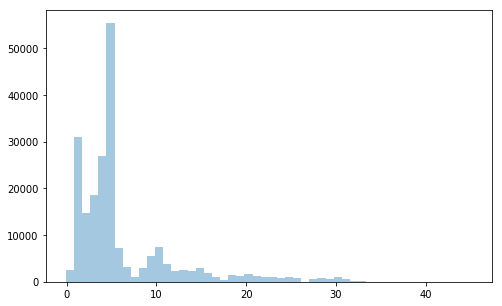

In [134]:
lop_df = example_df[[True if i != '' else False for i in example_df['length_of_project']]]
fig = plt.figure(figsize=(8,5))
lop_list = [i for i in lop_df['length_of_project']]
sns.distplot(lop_list, kde=False)
print(stats.describe(lop_list))
plt.show()

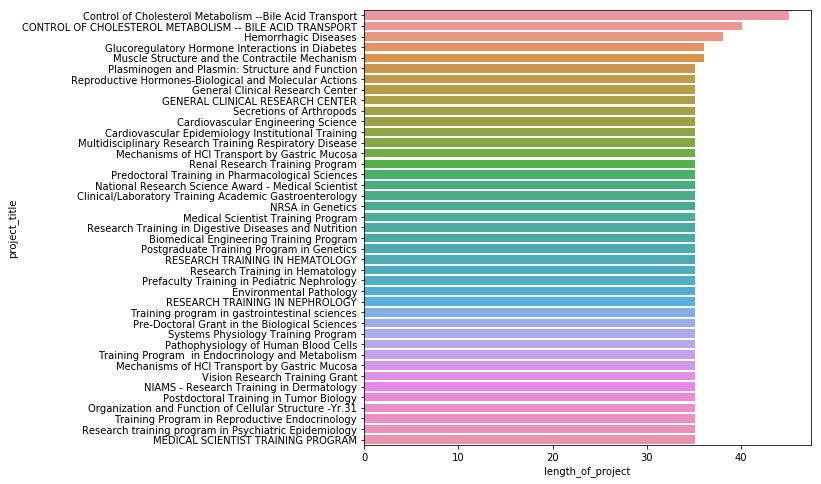

In [141]:
n = 50

trunc_lop_df = lop_df.sort_values('length_of_project', ascending=False).iloc[0:n, :]


fig = plt.figure(figsize=(8,8))
sns.barplot(trunc_lop_df['length_of_project'], trunc_lop_df['project_title'])
plt.show()


### Mean org distribution

Text(0.5, 0, "Organization's Mean Length of Project")

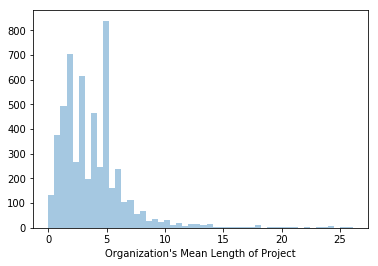

In [221]:
org_group_lop_df = lop_df[['org_name', 'length_of_project']].groupby('org_name').agg(['sum', 'count'])
org_group_lop_df['mean'] = org_group_lop_df['length_of_project']['sum'] / org_group_lop_df['length_of_project']['count']

sns.distplot(org_group_lop_df['mean'], kde=False)
plt.xlabel('Organization\'s Mean Length of Project')

### Longest orgs on average

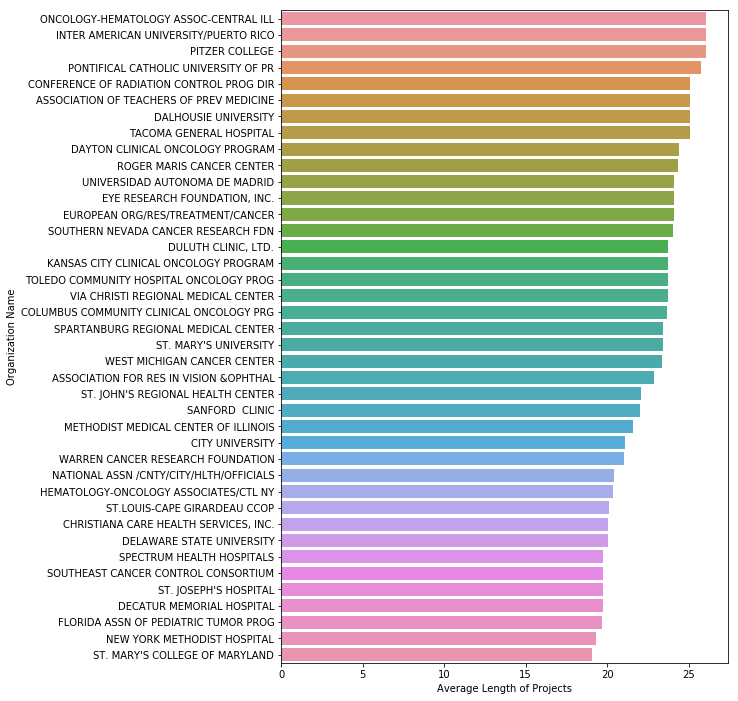

In [189]:
n = 40

trunc_group_lop_df = org_group_lop_df.sort_values('mean', ascending=False).iloc[0:n, :]


fig = plt.figure(figsize=(8,12))
sns.barplot(trunc_group_lop_df['mean'], trunc_group_lop_df.index)
plt.xlabel('Average Length of Projects')
plt.ylabel('Organization Name')
plt.show()


### Quickest Average Orgs

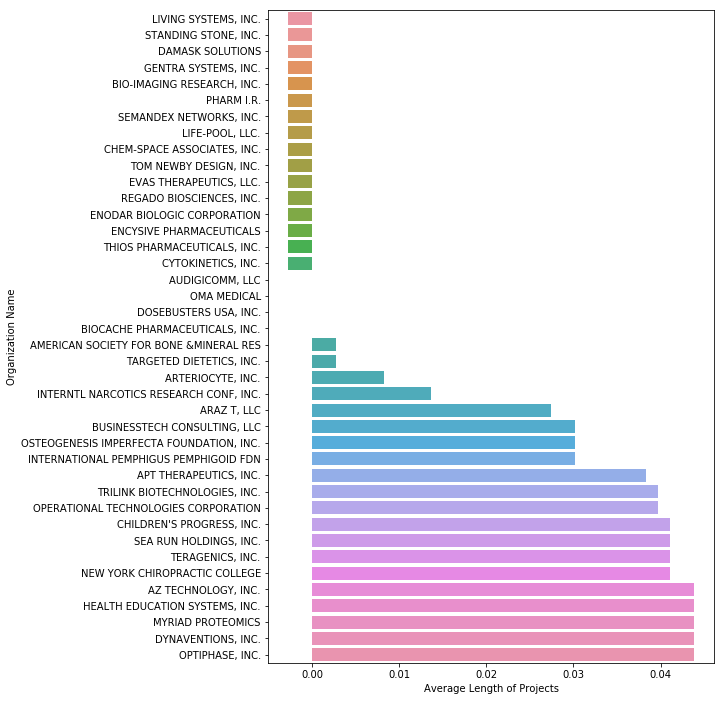

In [190]:
n = 40
trunc_group_lop_df = org_group_lop_df.sort_values('mean', ascending=True).iloc[0:n, :]


fig = plt.figure(figsize=(8,12))
sns.barplot(trunc_group_lop_df['mean'], trunc_group_lop_df.index)
plt.xlabel('Average Length of Projects')
plt.ylabel('Organization Name')
plt.show()


### Top average institutes

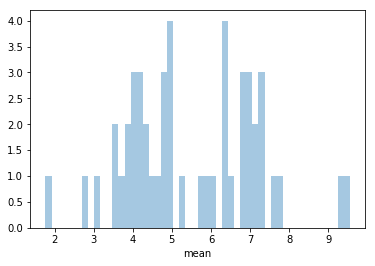

In [183]:
ic_group_lop_df = lop_df[['ic_name', 'length_of_project']].groupby('ic_name').agg(['sum', 'count'])
ic_group_lop_df['mean'] = ic_group_lop_df['length_of_project']['sum'] / ic_group_lop_df['length_of_project']['count']

sns.distplot(ic_group_lop_df['mean'], kde=False, bins=50)

### Top institutes on average

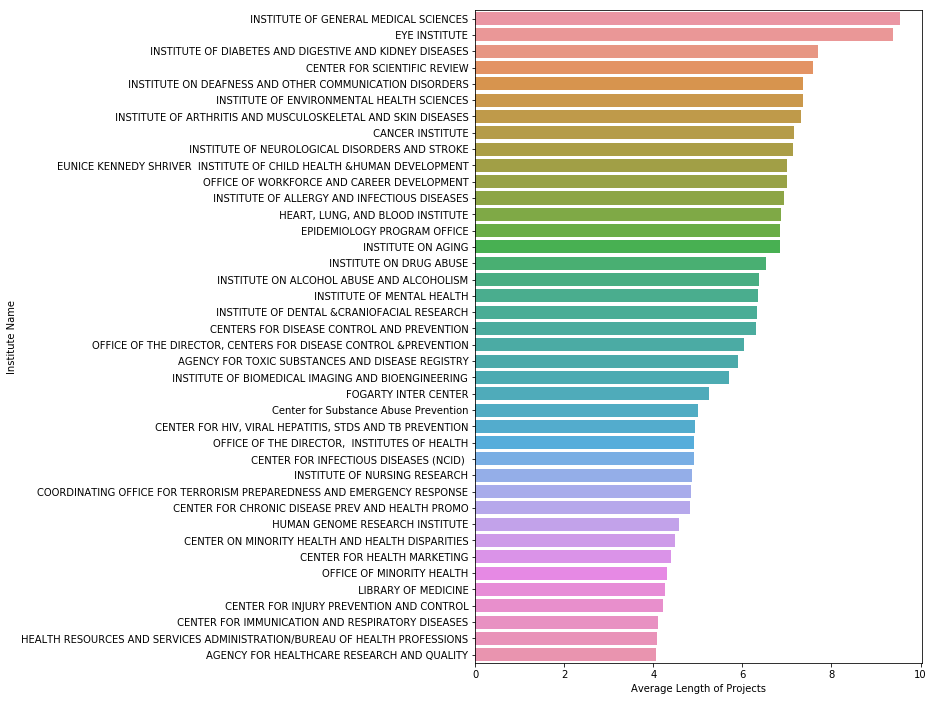

In [188]:
n = 40

trunc_group_ic_lop_df = ic_group_lop_df.sort_values('mean', ascending=False).iloc[0:n, :]
trunc_group_ic_lop_df.index = [i.replace('NATIONAL', '') for i in trunc_group_ic_lop_df.index]

fig = plt.figure(figsize=(8,12))
sns.barplot(trunc_group_ic_lop_df['mean'], trunc_group_ic_lop_df.index)
plt.xlabel('Average Length of Projects')
plt.ylabel('Institute Name')
plt.show()


## Org_name

In [215]:
organizations_df = example_df.dropna(axis=0,subset=['org_name'])
uni_pattern = '(UNIVERSITY)|(COLLEGE)|(SCHOOL)|( ?UNIV )|( COL ?)|( SCH ?)'
uni_organizations = [i for i in organizations_df['org_name'] if re.search(uni_pattern, i)]
n_data_rows = len(organizations_df['org_name'])
n_uni_rows = len(uni_organizations)
pct_uni = round(len(uni_organizations) / len(organizations_df['org_name']), 4)
print(f'Number of rows in data : {n_data_rows}\nNumber of College/Universities : {n_uni_rows} ({pct_uni}%)')

Number of rows in data : 222509
Number of College/Universities : 165582 (0.7442%)


### Colleges

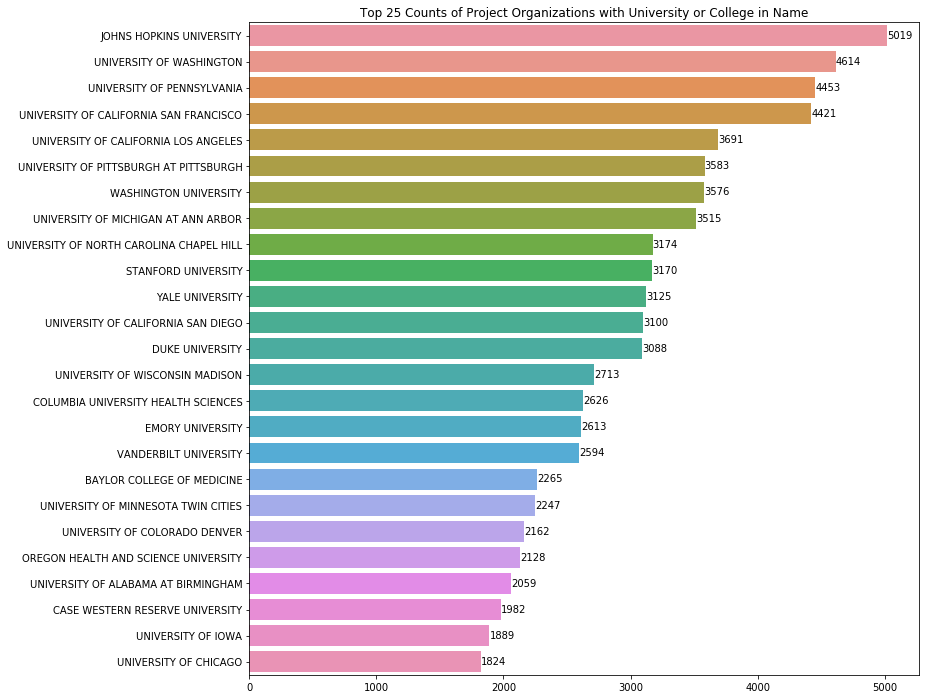

In [216]:
uni_df = organizations_df[[True if re.search(uni_pattern, i) else False for i in organizations_df['org_name']]]

n = 25

uni_counts_dict = collections.Counter(uni_df['org_name'])

top_count_unis = sorted(uni_counts_dict, key=uni_counts_dict.get, reverse=True)[:n]
top_unis_count = [uni_counts_dict[i] for i in top_count_unis]
#uni_counts = uni_counts[uni_counts.keys()[:50]]

fig = plt.figure(figsize=(12,12))

sns.barplot(top_unis_count, top_count_unis)

for i, v in enumerate(top_unis_count):
    plt.gca().text(v+1, i+.1, str(v), fontsize=10)
    
plt.title(f'Top {n} Counts of Project Organizations with University or College in Name')
plt.show()

### Top Companies

In [217]:
company_df = organizations_df[[False if re.search(uni_pattern, i) else True for i in organizations_df['org_name']]]

print(company_df.shape)

(56927, 43)


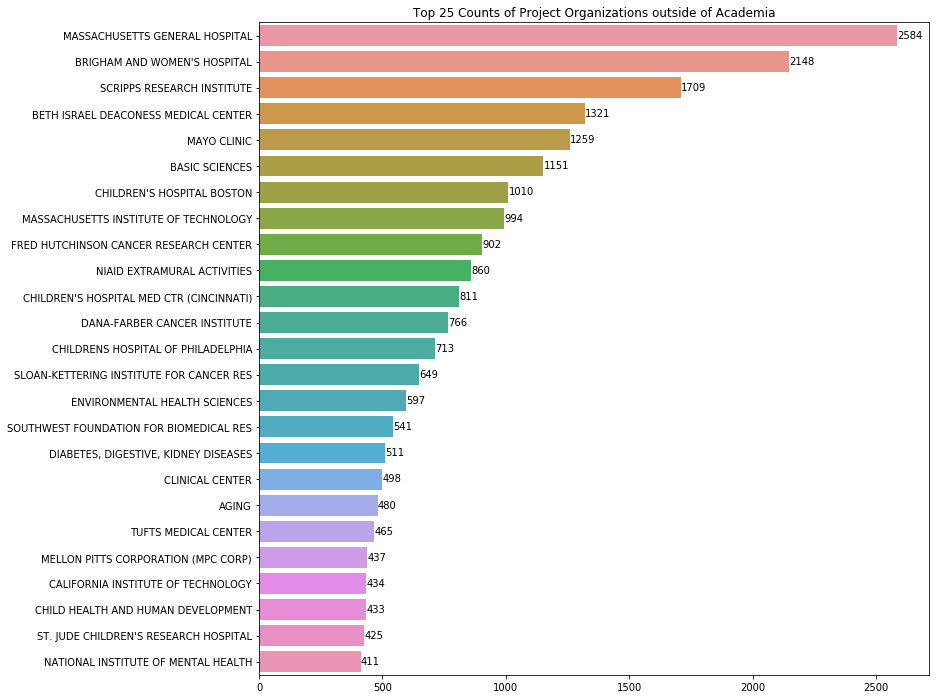

In [218]:
n = 25

comp_counts_dict = collections.Counter(company_df['org_name'])

top_count_comp = sorted(comp_counts_dict, key=comp_counts_dict.get, reverse=True)[:n]
top_comp_count = [comp_counts_dict[i] for i in top_count_comp]
#uni_counts = uni_counts[uni_counts.keys()[:50]]

fig = plt.figure(figsize=(12,12))

sns.barplot(top_comp_count, top_count_comp)

for i, v in enumerate(top_comp_count):
    plt.gca().text(v+1, i+.1, str(v), fontsize=10)
    
plt.title(f'Top {n} Counts of Project Organizations outside of Academia')
plt.show()

## ic_name

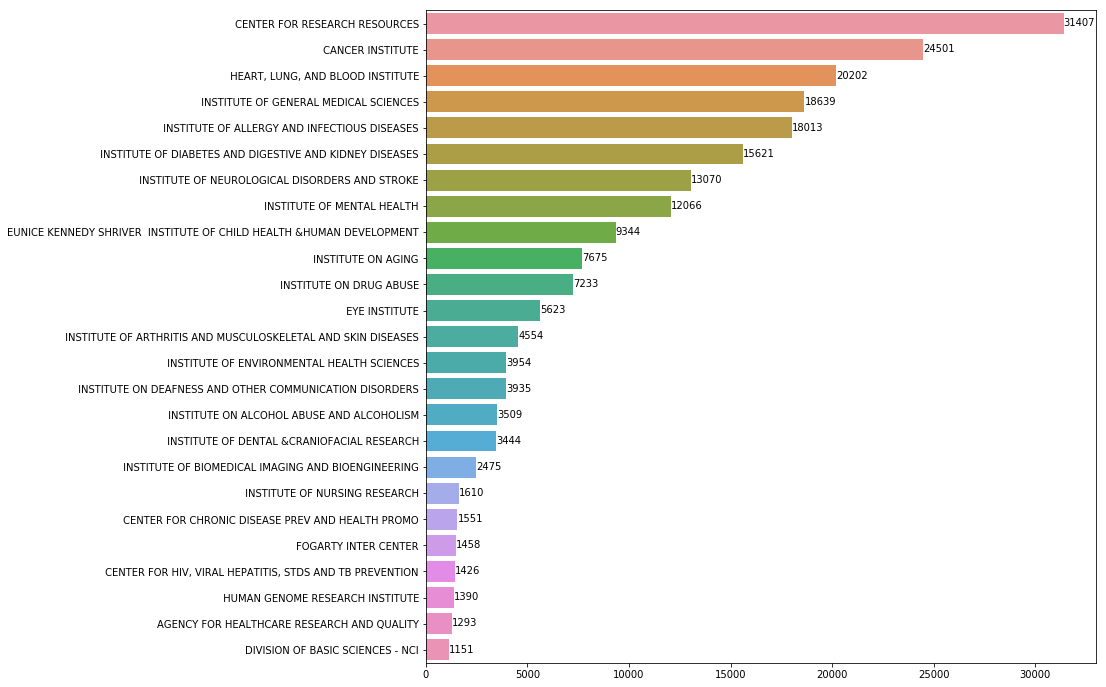

In [79]:
instit_df = example_df.dropna(axis=0,subset=['ic_name'])

n = 25

ic_name_counts_dict = collections.Counter(instit_df['ic_name'])

top_count_ic_name = sorted(ic_name_counts_dict, key=ic_name_counts_dict.get, reverse=True)[:n]
top_ic_name_count = [ic_name_counts_dict[i] for i in top_count_ic_name]
#uni_counts = uni_counts[uni_counts.keys()[:50]]

fig = plt.figure(figsize=(12,12))

top_count_ic_name = [i.replace('NATIONAL', '') for i in top_count_ic_name]

sns.barplot(top_ic_name_count, top_count_ic_name)

for i, v in enumerate(top_ic_name_count):
    plt.gca().text(v+1, i+.1, str(v), fontsize=10)

plt.show()

### total_cost

In [247]:
import numpy as np
tc_df = example_df[[True if (i != '') and (i is not None) else False for i in example_df['total_cost']]]
tc_df = tc_df[['total_cost', 'administering_ic', 'application_type', 'funding_ics', 'fy','org_city', 'org_country', 'org_district', 'org_duns', 'org_dept','org_fips', 'org_state', 'org_zipcode', 'ic_name', 'org_name']]
for column in ['total_cost', 'administering_ic', 'application_type', 'funding_ics', 'fy','org_city', 'org_country', 'org_district', 'org_duns', 'org_dept','org_fips', 'org_state', 'org_zipcode', 'ic_name', 'org_name']:
    tc_dummies_df = tc_df[column]
    tc_df = pd.concat([tc_df, tc_dummies_df], axis=1)
    tc_df = tc_df.drop(column, axis=1)
tc_df.head()


""
6050928
6052019
6175078
6185132
6193817


In [246]:
tc_list = [np.log10(int(i)) for i in tc_df['total_cost']]


sns.distplot(tc_list, kde=False)
plt.xlabel('log10(total_cost)')


In [240]:
cor

""
